# Business Analytics Commando - Everli

Specifics:
- This notebook was built using Python 3.9.1
- The libraries uses in the notebook are: `numpy`, `pandas`, `seaborn`, `matplotlib`, `sklearn (v0.24.2)`, `scipy.stats`

In [1]:
!python --version

Python 3.9.1


## Importing libraries and data

In [113]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from scipy.stats import t

sns.set()

In [3]:
data = pd.read_csv("data/analytics_task_data.csv")

## Preliminary exploration

In [4]:
print(f"Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}")

Number of rows: 500 
Number of columns: 2


In [5]:
data.describe()

,x,y
count,488.000000,462.000000
mean,10.649274,251.418730
std,2.209457,233.150756
min,7.001618,3.751412
25%,8.788517,69.000816
50%,10.539698,152.701811
75%,12.670049,391.265698
max,14.482900,888.310387


At first glance we see that the distribution of y is much wider in terms of variance with respect to x, and also that its mean is higher. Let's see them in two histograms

<ipython-input-6-19a7d74f1907>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


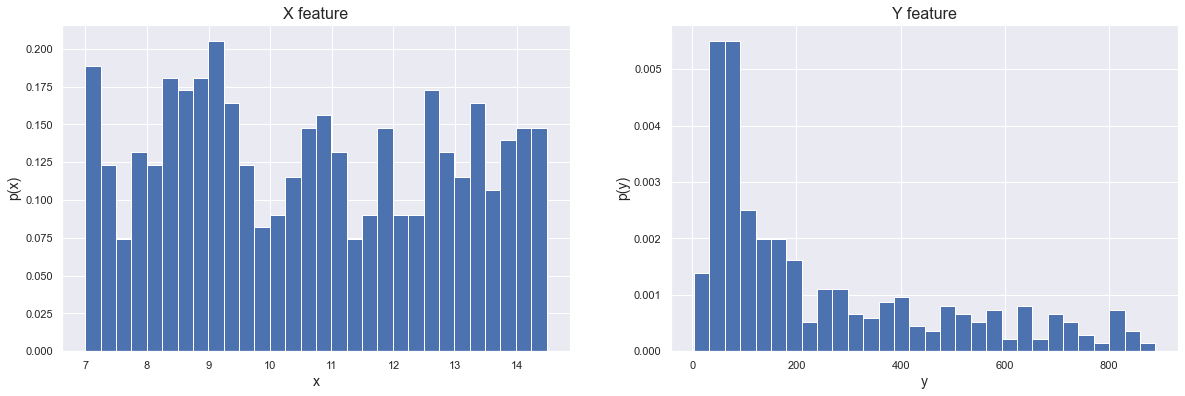

In [6]:
fig, axes = plt.subplots(1,2, figsize=(20,6))
axes[0].hist(data.x,density=True,stacked=True,bins=30)
axes[0].set_title("X feature", fontsize=16)
axes[0].set_xlabel("x", fontsize=14)
axes[0].set_ylabel("p(x)", fontsize=14)
axes[1].hist(data.y,density=True,stacked=True,bins=30)
axes[1].set_title("Y feature", fontsize=16)
axes[1].set_xlabel("y", fontsize=14)
axes[1].set_ylabel("p(y)", fontsize=14)
fig.show()

We can observe that the x feature has a range which is quite narrow with respect to y. On the other hand, x doesn't show particular skewness, while y instead appears to be strongly left skewed. The target variable presents itself with a peak of data in values around 100, which then gradually decreases but remains stable until reaching values over 800.

In [7]:
print(f"Skewness:\n{data.skew()}\n\nKurtosis:\n{data.kurtosis()}")

Skewness:
x    0.094107
y    1.079902
dtype: float64

Kurtosis:
x   -1.259837
y   -0.025213
dtype: float64


Let's see the boxplots of the two variables

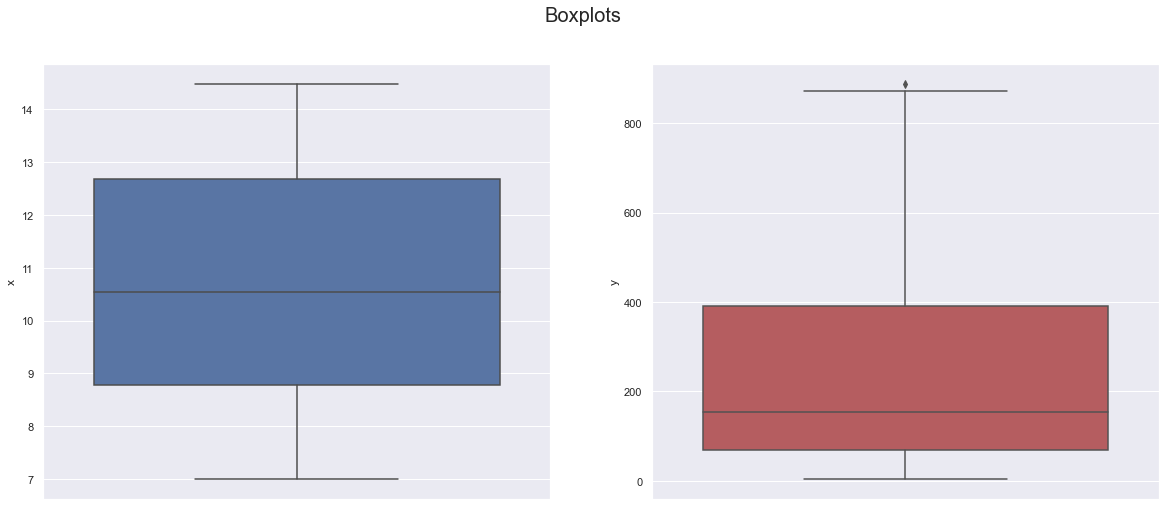

In [8]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(ax=axes[0],data=data,y="x",color="b")
sns.boxplot(ax=axes[1],data=data,y="y",color="r")
plt.suptitle("Boxplots",fontsize=20)
plt.show()

These boxplots confirm our first idea about the distribution of x and y. Moreover they give us insights into how to handle missing data. In fact, since y is much skewed, one should be careful in filling the gaps with the mean or the median.
Since we have just one dimension, let's see the data in a scatter plot.

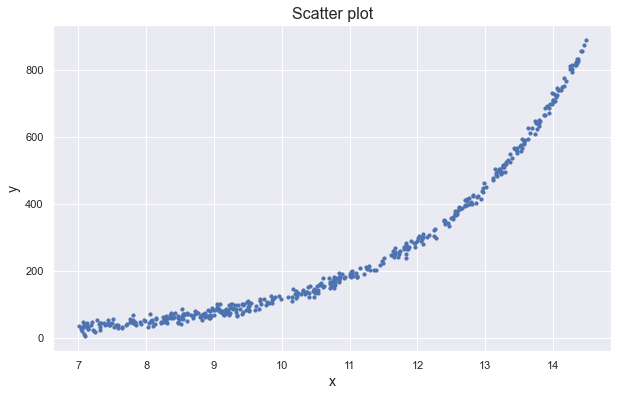

In [9]:
plt.figure(figsize=(10,6))
plt.scatter(data.x,data.y,s=10)
plt.xlabel("x",fontsize=14)
plt.ylabel("y",fontsize=14)
plt.title("Scatter plot",fontsize=16)
plt.show()

Thanks to the scatter plot, we are able to gain a lot of useful insights about the data. Even though the relationship between x and y doesn't appear to linear, we can observe that it might be of polynomial nature. This is a useful suggestion, since now we can think about doing a basis expansion of the feature x and maybe hope to fit a model using these new bases as regressors. Let's have a look at the correlation between x and y.

In [10]:
data.corr()

,x,y
x,1.000000,0.926637
y,0.926637,1.000000


As suspected, x and y present with a very high positive correlation, more than 90%. This is very promising, since it might help us infer on what is the true nature of the data, and what mght have been their data generating process. In this case, if the DGP is truly polynomial, then by looking for the right degree of the polynomial expansion we should be able to predict the data in a better way.

### Missing Data
We see that the dataset contains some missing data. They are not a great number but we need to take care of them in order to proceed with the analysis. Let's see them here.

In [11]:
count = data.isna().sum() # count the number of NaNs
mask_nan = data.isna().any(1) # create a mask to see them
both = data.isna().all(1).sum() # see if there is an entire pair of NaNs
print(f"The number of NaNs for x is: {count[0]}")
print(f"The number of NaNs for y is: {count[1]}")
print(f"The number of NaNs in both x and y is: {both}")

data[mask_nan].head(10)

The number of NaNs for x is: 12
The number of NaNs for y is: 38
The number of NaNs in both x and y is: 1


,x,y
17,11.765291,NaN
36,NaN,538.134513
43,10.521072,NaN
57,8.564607,NaN
64,13.346486,NaN
73,9.281438,NaN
94,9.580991,NaN
99,7.166841,NaN
118,7.458353,NaN
128,NaN,68.900925


We will proceed as follows since the missing data have different characteristics:
- the one datum who is missing both columns gets discarded;
- the data for which only y is missing can be inferred by a KNN average of x on y;
- the data for which only x is missing can also be inferred by a KNN average of y on x.

In this particular case, the use of a KNN Regression in both cases is justified by the scatter plot of the data seen above. Since we don't observe any particular important fluctuations, we can assume that the missing data follow the existing pattern in the dataset.
To carry out the imputation, we can use the new class of `sklearn` called `KNNImputer`.

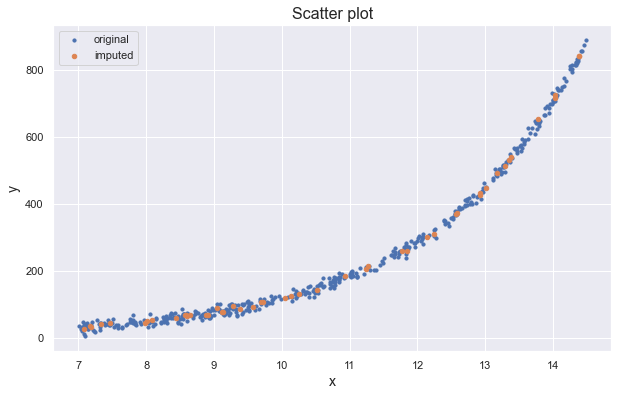

In [12]:
data = data.dropna(how="all") # drop the row with both missing
mask_nan = data.isna().any(1)
knn_imp = KNNImputer()
df = pd.DataFrame(knn_imp.fit_transform(data),columns=data.columns) # create a new dataframe where the empty cells have been filled by the KNN
assert not df.isna().any().any() #check that we have no more missing

plt.figure(figsize=(10,6))
plt.scatter(data.x,data.y,s=10, label="original")
plt.scatter(df[mask_nan.values].x,df[mask_nan.values].y,s=20, label="imputed")
plt.xlabel("x",fontsize=14)
plt.ylabel("y",fontsize=14)
plt.title("Scatter plot",fontsize=16)
plt.legend()
plt.show()


By looking at the scatter plot after the imputation of the missing values we can see that KNN did a good job, since we can still see a clear pattern in the data and that the missing values were filled accordingly.

## Regression task

The first thing to do as soon as we move to the prediction part is to take out part of our data and keep them as test set. That is, we will use the rest as training set, fit the models on these and then compare the performance of the models on the unseen test set. We need to do this in order to avoid biased results in our evaluation metrics, which could lead us to be overconfident of the model's capabilities.

In [194]:
X = df[["x"]].to_numpy() # separate the regressor
y = df.y.to_numpy()      # from the target variable
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=1234) # set the random state to have reproducible results

We will therefore keep aside (`X_test`,`y_test`) to perform the evaluation on these.

In [14]:
def compute_metrics(y_true,y_pred):
    '''Useful function for metrics computation'''
    print(f"MSE \t{mean_squared_error(y_true,y_pred):.4f}")
    print(f"RMSE \t{np.sqrt(mean_squared_error(y_true,y_pred)):.4f}")
    print(f"MAE \t{mean_absolute_error(y_true,y_pred):.4f}")
    print(f"R2 \t{r2_score(y_true,y_pred):.5f}")
    print()

### Linear Regression
Although we have seen that the relationship between x and y is clearly not linear, it's always a good choice to start from a simple OLS regression. If anything, this can provide us with a baseline method with which to compare the others that will follow. Moreover, in this situation, this can be a good starting model upon which to build others more complex.

In [15]:
lr = LinearRegression()
lr.fit(X_train,y_train)
print("Training error:\n")
compute_metrics(y_train,lr.predict(X_train))

Training error:

MSE 	7552.1649
RMSE 	86.9032
MAE 	72.5440
R2 	0.85688



In [16]:
print("Test error:\n")
compute_metrics(y_test,lr.predict(X_test))

Test error:

MSE 	7679.8998
RMSE 	87.6350
MAE 	69.5292
R2 	0.86696



The training and test error appear similar, meaning that the fit went well and we can expect the model to behave similarly on unseen data.

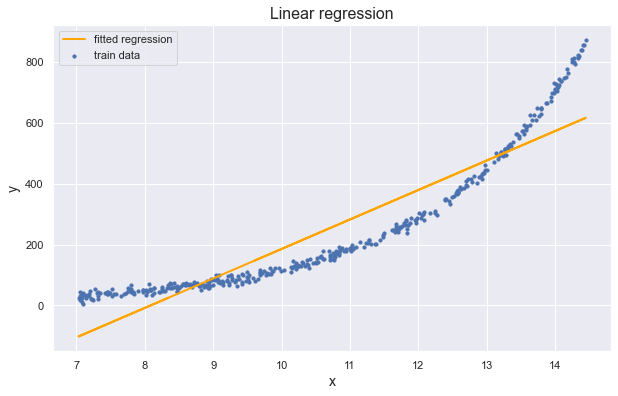

In [17]:
plt.figure(figsize=(10,6))
plt.scatter(X_train,y_train,s=10, label="train data")
plt.plot(X_train,lr.predict(X_train),label="fitted regression",linewidth=2,c="orange")
plt.xlabel("x",fontsize=14)
plt.ylabel("y",fontsize=14)
plt.title("Linear regression",fontsize=16)
plt.legend()
plt.show()

Our simple linear regression has a $R^2$ score of 0.86, which is quite good as a baseline. However, in the plot we can see that the fitted values still make errors in predicting certain values of x. From here, we can think of expanding the linear model, by adding more features computed from x.

### Basis Expansion

To perform a polynomial expansion we must choose the highest degree of the polynomial. This has consequences on the estimated model since a higher degree implies that the new regression would have more features, and we could run the risk of observing better predictions simply by adding useless regressors.
To choose `max_degree`, we have to use cross validation. We will do so by splitting the training set into 5 folds, keeping apart one at the time, and trying to fit the same polynomial model on the remaining ones. Then we will obtain a score on the one not used, and average across the five scores found, one for each fold.

To choose the best model we will try to minimize the Mean Squared Error, or equivalently the Residual Sum of Squares.

#### Cross Validation

In [144]:
degrees = range(1,11)

cv = KFold(n_splits=5,shuffle=True,random_state=1234)

metrics_poly = []

for d in degrees:
    mse = []
    poly_reg = Pipeline([('poly',PolynomialFeatures(degree=d)),
                        ('reg',LinearRegression())])
    for train_index, val_index in cv.split(X_train):
        k_pred = poly_reg.fit(X_train[train_index],y_train[train_index]).predict(X_train[val_index])
        mse.append(mean_squared_error(y_train[val_index],k_pred))
    metrics_poly.append(np.mean(mse))
    print(f"degree: {d} \t MSE = {np.mean(mse):.4f}")

degree: 1 	 MSE = 7671.0506
degree: 2 	 MSE = 691.7019
degree: 3 	 MSE = 118.6878
degree: 4 	 MSE = 98.0316
degree: 5 	 MSE = 97.1026
degree: 6 	 MSE = 96.8747
degree: 7 	 MSE = 98.0967
degree: 8 	 MSE = 98.9359
degree: 9 	 MSE = 98.9302
degree: 10 	 MSE = 98.9407


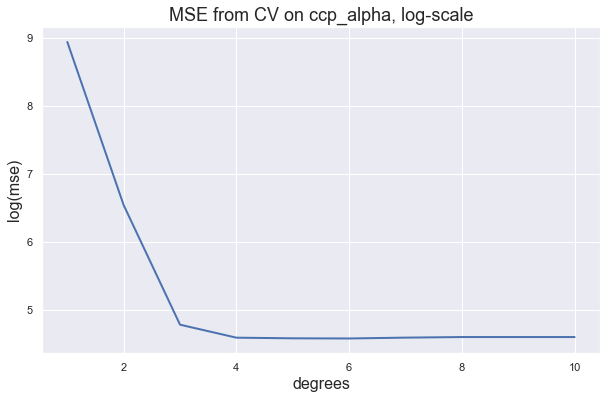

In [145]:
plt.figure(figsize=(10,6))
plt.plot(degrees,np.log(metrics_poly),linewidth=2)
plt.xlabel("degrees",fontsize=16)
plt.ylabel("log(mse)",fontsize=16)
plt.title("MSE from CV on ccp_alpha, log-scale",fontsize=18)
plt.show()

This is the result of the cross validation process, and each MSE estimate is the mean across all 5-folds of the training set. What we observe from the results is that once we have a polynomial of degree 4, the MSE stays quite constant even if we add predictors: this implies that the preferred degree of the polynomial is 4, since it is enough to reduce significantly the RSS and at the same time is the most parsimonious since it doesn't include unnecesary features.

Therefore, we'll now retrain the model on the whole training set, and we'll see how the polynomial regression performs on the test set.

In [163]:
poly_reg = Pipeline([('poly',PolynomialFeatures(degree=4,include_bias=False)),
                        ('reg',LinearRegression())])
poly_reg.fit(X_train,y_train)
print("Training error:\n")
compute_metrics(y_train,poly_reg.predict(X_train))
X_poly_test = poly.transform(X_test)
print("Test error:\n")
compute_metrics(y_test,poly_reg.predict(X_test))

Training error:

MSE 	95.6314
RMSE 	9.7791
MAE 	7.6711
R2 	0.99819

Test error:

MSE 	83.8384
RMSE 	9.1563
MAE 	7.4320
R2 	0.99855



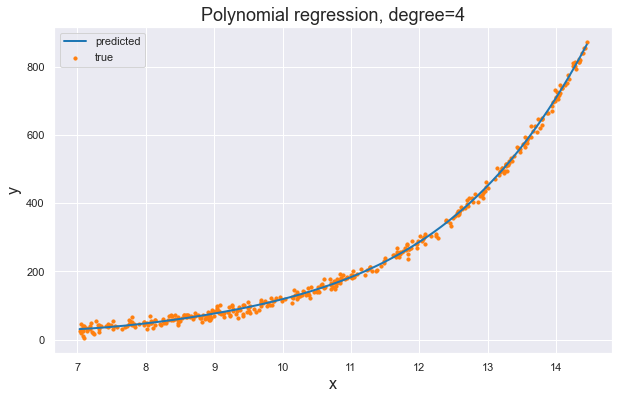

In [164]:
interval = np.linspace(X_train.min(),X_train.max(),500).reshape(-1,1)
plt.figure(figsize=(10,6))
plt.scatter(X_train,y_train,s=10,label="true",color="tab:orange")
plt.plot(interval,poly_reg.predict(interval),linewidth=2,label="predicted",color="tab:blue")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.title("Polynomial regression, degree=4",fontsize=18)
plt.legend()
plt.show()

In [165]:
print(f"The intercept of the regression is {poly_reg.steps[1][1].intercept_}\n")
for i, coef in enumerate(poly_reg.steps[1][1].coef_):
    print(f"The coefficient of x^{i+1} is: \t{coef:.3f}")

The intercept of the regression is 1617.0519384544432

The coefficient of x^1 is: 	-745.243
The coefficient of x^2 is: 	129.180
The coefficient of x^3 is: 	-9.984
The coefficient of x^4 is: 	0.302


### Decision Tree Regressor

In [26]:
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
print("Training error:\n")
compute_metrics(y_train,dt.predict(X_train))
print("Test error:\n")
compute_metrics(y_test,dt.predict(X_test))

Training error:

MSE 	0.0000
RMSE 	0.0000
MAE 	0.0000
R2 	1.00000

Test error:

MSE 	147.5404
RMSE 	12.1466
MAE 	9.9383
R2 	0.99744



#### Cross Validation

In [27]:
alphas = [0.1*i for i in range(1,30)]
metrics_dt = []
for a in alphas:
    mse = []
    for train_index, val_index in cv.split(X_train):
        k_pred = DecisionTreeRegressor(ccp_alpha=a).fit(X_train[train_index],y_train[train_index]).predict(X_train[val_index])
        mse.append(mean_squared_error(y_train[val_index],k_pred))
    metrics_dt.append(np.mean(mse))
    print(f"alpha: {a:.1f}\tMSE = {np.mean(mse):.4f}")

alpha: 0.1	MSE = 187.5508
alpha: 0.2	MSE = 182.0848
alpha: 0.3	MSE = 177.0345
alpha: 0.4	MSE = 171.5387
alpha: 0.5	MSE = 159.3440
alpha: 0.6	MSE = 150.0817
alpha: 0.7	MSE = 146.9777
alpha: 0.8	MSE = 147.2038
alpha: 0.9	MSE = 141.2037
alpha: 1.0	MSE = 141.0400
alpha: 1.1	MSE = 139.8400
alpha: 1.2	MSE = 138.5124
alpha: 1.3	MSE = 142.9755
alpha: 1.4	MSE = 144.5307
alpha: 1.5	MSE = 149.3568
alpha: 1.6	MSE = 146.8428
alpha: 1.7	MSE = 151.6474
alpha: 1.8	MSE = 155.7110
alpha: 1.9	MSE = 154.7892
alpha: 2.0	MSE = 154.7892
alpha: 2.1	MSE = 154.7892
alpha: 2.2	MSE = 155.3709
alpha: 2.3	MSE = 156.2143
alpha: 2.4	MSE = 156.2143
alpha: 2.5	MSE = 156.2143
alpha: 2.6	MSE = 158.9132
alpha: 2.7	MSE = 159.6413
alpha: 2.8	MSE = 160.3011
alpha: 2.9	MSE = 160.3011


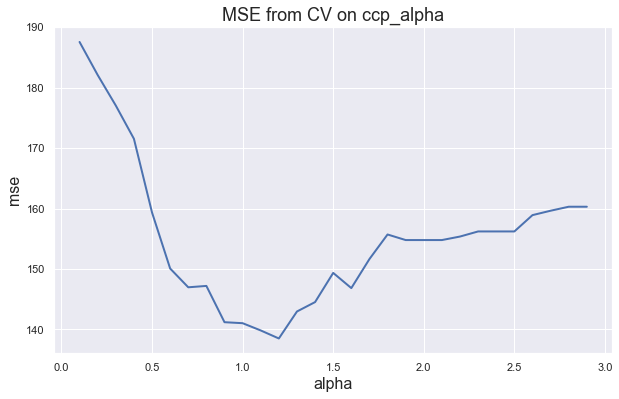

In [28]:
plt.figure(figsize=(10,6))
plt.plot(alphas,metrics_dt,linewidth=2)
plt.xlabel("alpha",fontsize=16)
plt.ylabel("mse",fontsize=16)
plt.title("MSE from CV on ccp_alpha",fontsize=18)
plt.show()

In [29]:
dt = DecisionTreeRegressor(ccp_alpha=1.2)
dt.fit(X_train,y_train)
print("Training error:\n")
compute_metrics(y_train,dt.predict(X_train))
print("Test error:\n")
compute_metrics(y_test,dt.predict(X_test))
print(f"The estimated tree has depth {dt.get_depth()} and {dt.get_n_leaves()} total leaves.")

Training error:

MSE 	66.4395
RMSE 	8.1510
MAE 	6.4733
R2 	0.99874

Test error:

MSE 	142.7192
RMSE 	11.9465
MAE 	9.4677
R2 	0.99753

The estimated tree has depth 8 and 43 total leaves.


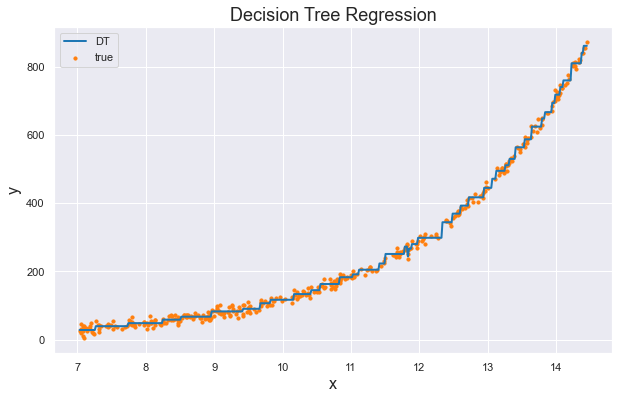

In [30]:
interval = np.linspace(X_train.min(),X_train.max(),500).reshape(-1,1)
plt.figure(figsize=(10,6))
plt.scatter(X_train,y_train,s=10,label="true",color="tab:orange")
plt.plot(interval,dt.predict(interval),label="DT",linewidth=2,color="tab:blue")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.title("Decision Tree Regression",fontsize=18)
plt.legend()
plt.show()

### Models comparison
#### Nested Cross Validation

In [167]:
def mse_scorer(estimator,X,y):
    return mean_squared_error(y,estimator.predict(X))

inner_cv = 5
outer_cv = 5

# Decision Tree
alphas = {'ccp_alpha':[0.1*i for i in range(1,30)]}
dt = DecisionTreeRegressor()
best_tree = GridSearchCV(estimator=dt,param_grid=alphas,cv=inner_cv,n_jobs=-1,verbose=1)
# Polynomial Regression
degrees = {'poly__degree':[d for d in range(1,11)]}
poly_reg = Pipeline([('poly',PolynomialFeatures(include_bias=False)),
                     ('reg',LinearRegression())])
best_reg = GridSearchCV(estimator=poly_reg,param_grid=degrees,cv=inner_cv,n_jobs=-1,verbose=1)

# Performance evaluation by CV
mse_poly = cross_val_score(best_reg,X,y,cv=outer_cv,scoring=mse_scorer)
mse_tree = cross_val_score(best_tree,X,y,cv=outer_cv,scoring=mse_scorer)

print(f"Polynomial Regression:\t{np.mean(mse_poly):.4f}")
print(f"Decision Tree:\t\t{np.mean(mse_dt):.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 29 candidates, totalling 145 fits
Fitting 5 folds for each of 29 candidates, totalling 145 fits
Fitting 5 folds for each of 29 candidates, totalling 145 fits
Fitting 5 folds for each of 29 candidates, totalling 145 fits
Fitting 5 folds for each of 29 candidates, totalling 145 fits
Polynomial Regression:	94.9926
Decision Tree:		209.3925


In [168]:
HP = "\"The two estimated MSE are equal\""

alpha_test = 0.1
delta = np.mean(mse_poly) - np.mean(mse_dt)
n = len(mse_poly)
sp = np.sqrt((np.var(mse_poly,ddof=1)+np.var(mse_dt,ddof=1))/n)
t_stat = delta/sp
p_value = t.cdf(t_stat,df=2*(n-1))
if p_value < alpha_test:
    print(f"p_value = {p_value:.5f} < alpha")
    print(f"Reject hypothesis: {HP}")
else:
    print(f"p_value = {p_value:.5f} > alpha")
    print(f"Fail to reject hypotesis: {HP} ")

p_value = 0.02041 < alpha
Reject hypothesis: "The two estimated MSE are equal"


### Conclusions

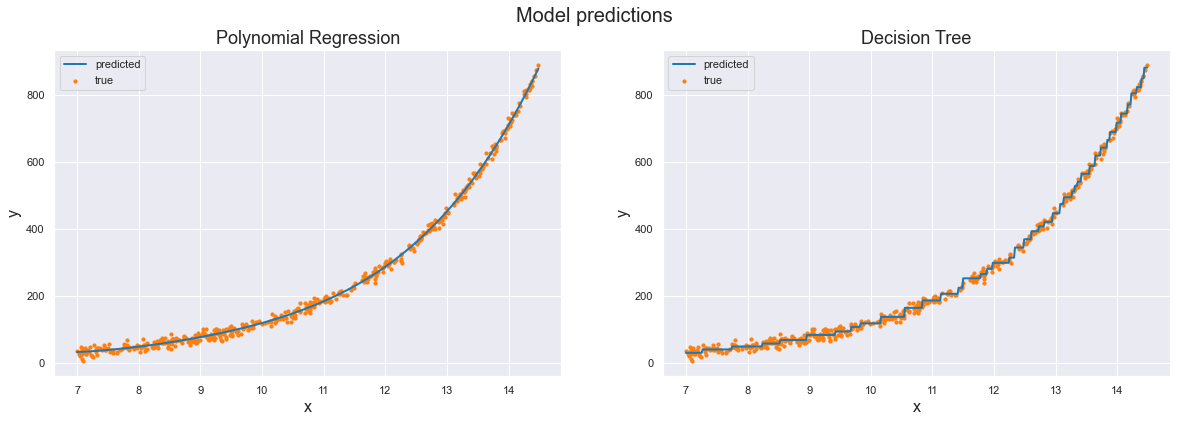

In [190]:
# Fit models on whole dataset
poly_reg = Pipeline([('poly',PolynomialFeatures(degree=4,include_bias=False)),
                     ('reg',LinearRegression())])
dt = DecisionTreeRegressor(ccp_alpha=1.2)
poly_reg.fit(X,y)
dt.fit(X,y)

# Compare the predictions in a plot
interval = np.linspace(X.min(),X.max(),500).reshape(-1,1)

fig, axes = plt.subplots(1,2,figsize=(20,6))
for ax, model in zip(axes,[poly_reg,dt]):
    ax.scatter(X,y,s=10,label="true",color="tab:orange")
    ax.plot(interval,model.predict(interval),label="predicted",linewidth=2,color="tab:blue")
    ax.set_xlabel("x",fontsize=16)
    ax.set_ylabel("y",fontsize=16)
    ax.legend()
axes[0].set_title("Polynomial Regression",fontsize=18)
axes[1].set_title("Decision Tree",fontsize=18)
fig.suptitle("Model predictions",fontsize=20)
plt.show()

## Extra modeling attempts

### Multi Layer Perceptron

In [33]:
hid_layers = [(i) for i in [10,25,50,100]] +\
             [(i,i) for i in [10,25,50,100]] +\
             [(i,i,i) for i in [10,25,50,100]] +\
             [(i,i,i,i) for i in [10,25,50,100]]

In [191]:
metrics_mlp = []

for h_l in hid_layers:
    mse = []
    mlp = Pipeline([('poly',PolynomialFeatures(degree=6,include_bias=True)),
                    ('mlp',MLPRegressor(hidden_layer_sizes=h_l,max_iter=5000,early_stopping=True,n_iter_no_change=50))])
    for train_index, val_index in cv.split(X_train):
        mlp.fit(X_train[train_index],y_train[train_index])
        mse.append(mean_squared_error(y_train[val_index],mlp.predict(X_train[val_index])))
    metrics_mlp.append((h_l,np.mean(mse)))
    print(h_l,"\t",np.mean(mse))


10 	 3218413.7066298975
25 	 48739610.20903383
50 	 362400.64836157125
100 	 5467.182990383057
(10, 10) 	 318955.4287082009
(25, 25) 	 2557.831122531114
(50, 50) 	 274122.2077065079
(100, 100) 	 6018.369906275252
(10, 10, 10) 	 2086627.0519231844
(25, 25, 25) 	 29258.742194281484
(50, 50, 50) 	 123844.20193317672
(100, 100, 100) 	 9393.472739243389
(10, 10, 10, 10) 	 30916.600395382975
(25, 25, 25, 25) 	 167203.98877015887
(50, 50, 50, 50) 	 1791.8345715030766
(100, 100, 100, 100) 	 1386.8047695143514


In [196]:
hid_lay = (25,25,25)

mlp1 = Pipeline([('poly',PolynomialFeatures(degree=6,include_bias=True)),
                    ('mlp',MLPRegressor(hidden_layer_sizes=h_l,max_iter=5000,early_stopping=True,n_iter_no_change=50))])
mlp1.fit(X_train,y_train)
print("Training error:\n")
compute_metrics(y_train,mlp1.predict(X_train))
print("Test error:\n")
compute_metrics(y_test,mlp1.predict(X_test))

Training error:

MSE 	630.9316
RMSE 	25.1184
MAE 	20.6392
R2 	0.98804

Test error:

MSE 	724.4197
RMSE 	26.9150
MAE 	22.2306
R2 	0.98745



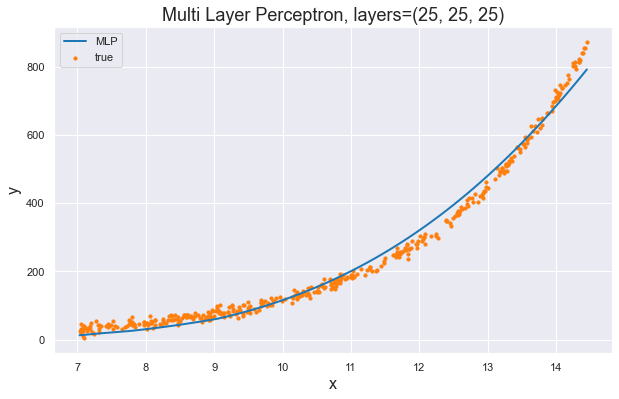

In [197]:
interval = np.linspace(X_train.min(),X_train.max(),100).reshape(-1,1)
plt.figure(figsize=(10,6))
plt.scatter(X_train,y_train,s=10,label="true",color="tab:orange")
plt.plot(interval,mlp1.predict(interval),label="MLP",linewidth=2,color="tab:blue")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.title(f"Multi Layer Perceptron, layers={hid_lay}",fontsize=18)
plt.legend()
plt.show()

In [198]:
hid_lay = (100,100)

mlp2 = Pipeline([('poly',PolynomialFeatures(degree=6,include_bias=True)),
                    ('mlp',MLPRegressor(hidden_layer_sizes=h_l,max_iter=5000,early_stopping=True,n_iter_no_change=50))])
mlp2.fit(X_train,y_train)
print("Training error:\n")
compute_metrics(y_train,mlp2.predict(X_train))
print("Test error:\n")
compute_metrics(y_test,mlp2.predict(X_test))

Training error:

MSE 	299.8802
RMSE 	17.3170
MAE 	14.4197
R2 	0.99432

Test error:

MSE 	313.8680
RMSE 	17.7163
MAE 	14.5272
R2 	0.99456



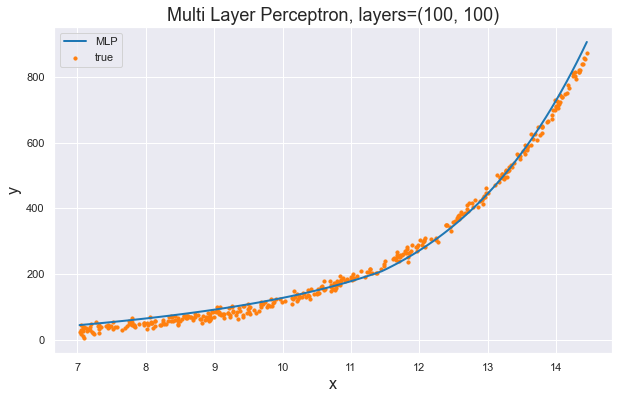

In [199]:
interval = np.linspace(X_train.min(),X_train.max(),100).reshape(-1,1)
plt.figure(figsize=(10,6))
plt.scatter(X_train,y_train,s=10,label="true",color="tab:orange")
plt.plot(interval,mlp2.predict(interval),label="MLP",linewidth=2,color="tab:blue")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.title(f"Multi Layer Perceptron, layers={hid_lay}",fontsize=18)
plt.legend()
plt.show()

In [200]:
hid_lay = (50,50,50,50)

mlp3 = Pipeline([('poly',PolynomialFeatures(degree=6,include_bias=True)),
                    ('mlp',MLPRegressor(hidden_layer_sizes=h_l,max_iter=5000,early_stopping=True,n_iter_no_change=50))])
mlp3.fit(X_train,y_train)
print("Training error:\n")
compute_metrics(y_train,mlp3.predict(X_train))
print("Test error:\n")
compute_metrics(y_test,mlp3.predict(X_test))

Training error:

MSE 	2077.6228
RMSE 	45.5809
MAE 	36.1038
R2 	0.96063

Test error:

MSE 	2251.0646
RMSE 	47.4454
MAE 	36.9407
R2 	0.96100



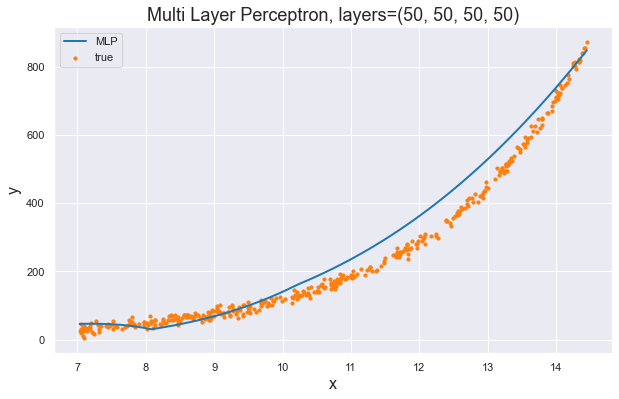

In [201]:
interval = np.linspace(X_train.min(),X_train.max(),100).reshape(-1,1)
plt.figure(figsize=(10,6))
plt.scatter(X_train,y_train,s=10,label="true",color="tab:orange")
plt.plot(interval,mlp3.predict(interval),label="MLP",linewidth=2,color="tab:blue")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.title(f"Multi Layer Perceptron, layers={hid_lay}",fontsize=18)
plt.legend()
plt.show()